<a href="https://colab.research.google.com/github/Amelrich/Capstone-Fall-2020/blob/kassie-preprocessing/romane_kassie_visualization_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
skipped_values = np.load('/content/drive/My Drive/capstone/skipped_values.npy')
consecutive_values = np.load('/content/drive/My Drive/capstone/consecutive_values.npy')

In [4]:
!pip install tslearn

     |████████████████████████████████| 778kB 2.8MB/s 


**1. Clustering with Skipped Multi-Scale** 

In [5]:
from tslearn.clustering import TimeSeriesKMeans

#Skipped values
km_skipped = TimeSeriesKMeans(n_clusters=10, metric="dtw", max_iter=5,random_state=0).fit(skipped_values)
clusters_skipped = km_skipped.predict(skipped_values)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
#Dictionnaries with keys = clusters, values = list of the chunks in that cluster
dict_skipped = {}

for i in range(0,10):
  dict_skipped[i] = list()

for ind, arr in enumerate(skipped_values):
  dict_skipped[clusters_skipped[ind]].append(arr)

In [7]:
copy_skipped = dict_skipped

In [8]:
#Number of chunks in each cluster
clusters_n = [len(j) for j in dict_skipped.values()]
clusters_n

[431, 315, 574, 219, 391, 380, 360, 616, 328, 386]

In [9]:
#Create a dataframe with each column = mean of the values of each chunk in the cluster for that day
for i in range(0,10):
  #Concatenate all arrays into dataframe
  dict_skipped[i] = pd.DataFrame(np.concatenate(dict_skipped[i], axis=1)).replace(0,np.nan) 

for i in range(0,10):
  #Compute the mean for each scale
  col_con = dict_skipped[i].loc[:,0::3]
  col_2s = dict_skipped[i].loc[:,1::3]
  col_3s = dict_skipped[i].loc[:,2::3]

  dict_skipped[i] = pd.concat([col_con.mean(axis=1), col_2s.mean(axis=1), col_3s.mean(axis=1)], axis =1).replace(np.nan, 0)
  dict_skipped[i].columns = ['consecutive_mean', 'two_step_mean', 'three_step_mean']

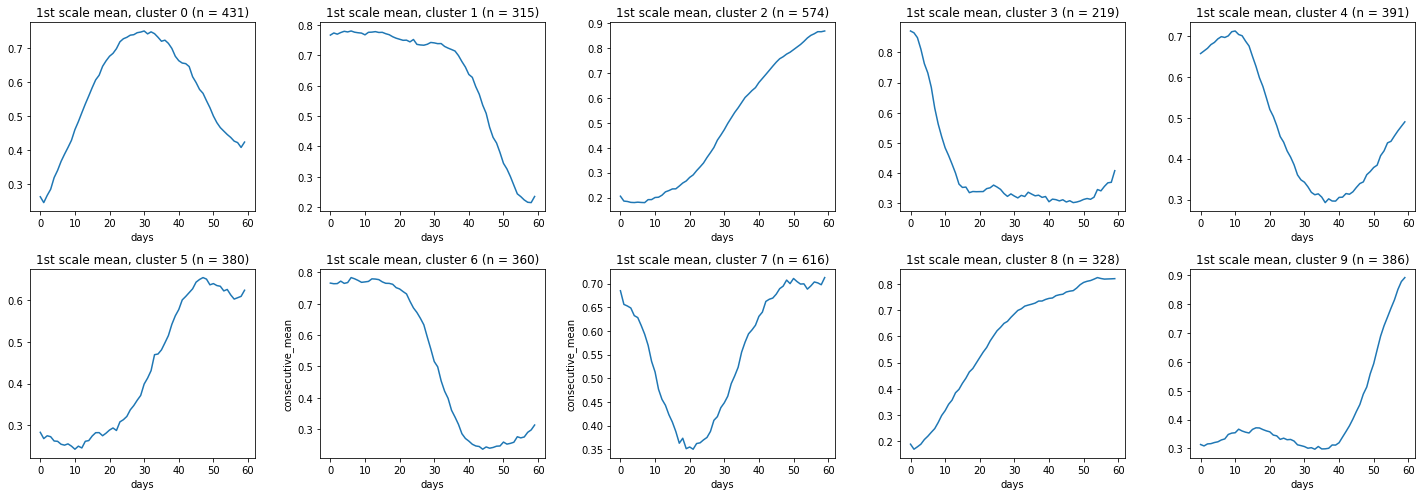

In [12]:
#Plotting the results
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 5, figsize = (20,7))

for i in range(0,10):
  if i < 5:
    sns.lineplot(data = dict_skipped[i]['consecutive_mean'], ax = ax[0, int(i)])
    ax[0,int(i)].set_title('1st scale mean, cluster ' + str(i) + ' (n = '+ str(clusters_n[int(i)])+')')
    ax[0,int(i)].set_ylabel('')
    ax[0,int(i)].set_xlabel('days')
  
  else:
    sns.lineplot(data = dict_skipped[i]['consecutive_mean'], ax = ax[1, int(5-i)])
    ax[1,int(i-5)].set_title('1st scale mean, cluster ' + str(i) + ' (n = '+ str(clusters_n[int(i)])+')')
    ax[1,int(i-5)].set_ylabel('')
    ax[1,int(i-5)].set_xlabel('days')

plt.tight_layout()

**2. Clustering with Consecutive Multi-Scale Values**

In [13]:
#Consecutive values
km_consecutive = TimeSeriesKMeans(n_clusters=10, metric="dtw", max_iter=5,random_state=0).fit(consecutive_values)
clusters_consecutive = km_consecutive.predict(consecutive_values)

In [14]:
#Dictionnaries with keys = clusters, values = list of the chunks in that cluster
dict_cons = {}

for i in range(0,10):
  dict_cons[i] = list()

for ind, arr in enumerate(consecutive_values):
  dict_cons[clusters_consecutive[ind]].append(arr)

In [15]:
#Number of chunks in each cluster
clusters_n_cons = [len(j) for j in dict_cons.values()]
clusters_n_cons

[334, 376, 316, 248, 348, 418, 779, 241, 400, 540]

In [16]:
#Create a dataframe with each column = mean of the values of each chunk in the cluster for that day
for i in range(0,10):
  #Concatenate all arrays into dataframe
  dict_cons[i] = pd.DataFrame(np.concatenate(dict_cons[i], axis=1)).replace(0,np.nan) 

for i in range(0,10):
  #Compute the mean for each scale
  col_20 = dict_cons[i].loc[:,0::3]
  col_40 = dict_cons[i].loc[:,1::3]
  col_60 = dict_cons[i].loc[:,2::3]

  dict_cons[i] = pd.concat([col_20.mean(axis=1), col_40.mean(axis=1), col_60.mean(axis=1)], axis =1).replace(np.nan, 0)
  dict_cons[i].columns = ['20d_mean', '40d_mean', '60d_mean']

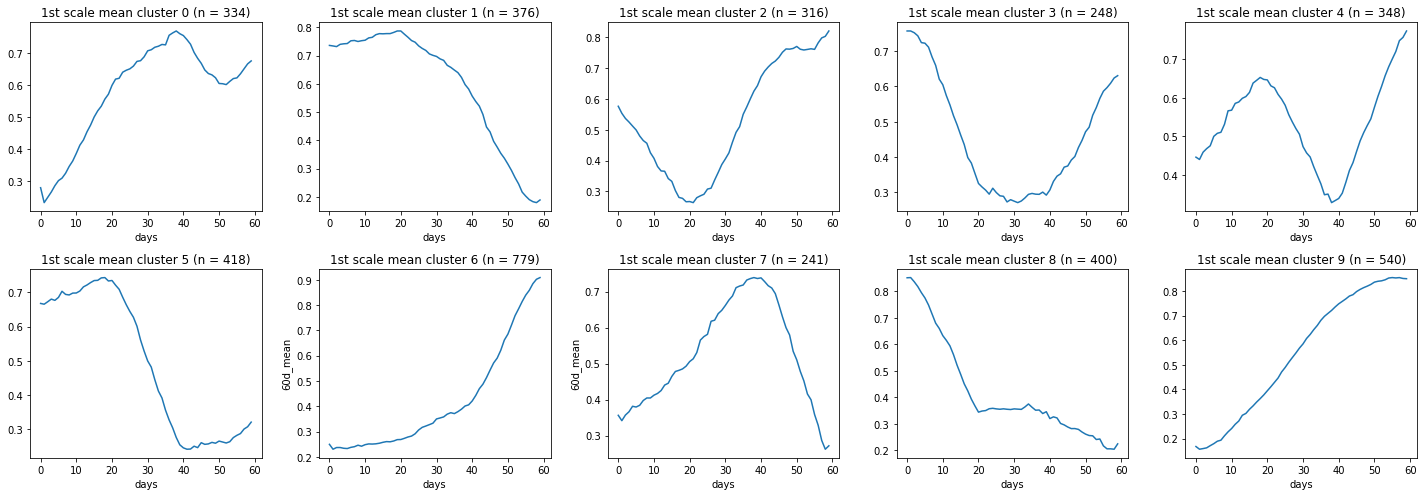

In [17]:
#Plotting the results
fig, ax = plt.subplots(2, 5, figsize = (20,7))

for i in dict_cons.keys():
  if i < 5:
    sns.lineplot(data = dict_cons[i]['60d_mean'], ax = ax[0, int(i)])
    ax[0,int(i)].set_title('1st scale mean cluster ' + str(i) + ' (n = '+ str(clusters_n_cons[int(i)])+')')
    ax[0,int(i)].set_ylabel('')
    ax[0,int(i)].set_xlabel('days')

  else:
    sns.lineplot(data = dict_cons[i]['60d_mean'], ax = ax[1, int(5-i)])
    ax[1,int(i-5)].set_title('1st scale mean cluster ' + str(i) + ' (n = '+ str(clusters_n_cons[int(i)])+')')
    ax[1,int(i-5)].set_ylabel('')
    ax[1,int(i-5)].set_xlabel('days')

plt.tight_layout()

In [18]:
import tslearn
from tslearn.metrics import dtw, cdist_dtw

def DTW(cluster_array):
    n = len(cluster_array)
    total_distance = 0
    # Nested loop for all possible pairs
    for i in range(n):
        for j in range(n):
            total_distance = total_distance + dtw(cluster_array[i], cluster_array[j])

    return total_distance

total = 0
for i in range(0,10):
  d = DTW(copy_skipped[i])
  total = total + d
  print("Cluster {} has distance {}".format(i, d))

KeyError: ignored

In [ ]:
total

10900375.824580576